# Gaussian Process Regression for Solar Irradiance to Power

In this notebook we will go through the task of irradiance to power conversion using Gaussian Process Regression as our model.  

For a walk-through of the data we are using, please see the notebook "advanced_DTU_introduction_to_data.ipynb"

Please see the accompanying paper for a theoretical description of the algorithm. This notebook is only going to implement the model for our specific task and report on the results obtained.

In [3]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from py_utils import nc_to_pd, prepare_simulated, plot_gp

from sklearn.preprocessing import StandardScaler

import math
# import torch

from sklearn.preprocessing import StandardScaler

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, ExpSineSquared, ConstantKernel, Matern, WhiteKernel

from matplotlib import pyplot as plt

In [4]:
if sys.platform == 'win32':
    save_folder = "F:/Google Drive/Dropbox_Backup/Post Study/Industrial/Courses/DTU Advanced Machine Learning, 2020/Data/"
else:
    save_folder = ""

# 1. Data

We will treat each synthetic solar plant as an independent sample, which is reasonable given that they might have very different solar panels and thus a different efficiency standard!

In [5]:
#  We import the data that we described in the "advanced_DTU_introduction_to_data.ipynb" notebook.
meuro_sim = pd.read_csv(save_folder + 'meuro_simulated.csv', skiprows=[0,1,2])
neuhardenberg_sim = pd.read_csv(save_folder + 'neuhardenberg_simulated.csv', skiprows=[0,1,2])
templin_sim = pd.read_csv(save_folder + 'templin_simulated.csv', skiprows=[0,1,2])


# We give them appropriate timestamps (UTC time)
meuro_irradiance = pd.read_csv(save_folder + 'irradiance_meuro_data.csv').set_index('time')
meuro_irradiance.index = pd.to_datetime(meuro_irradiance.index, utc=True)

neuhardenberg_irradiance = pd.read_csv(save_folder + 'irradiance_neuhardenberg_data.csv').set_index('time')
neuhardenberg_irradiance.index = pd.to_datetime(neuhardenberg_irradiance.index, utc=True)

templin_irradiance = pd.read_csv(save_folder + 'irradiance_templin_data.csv').set_index('time')
templin_irradiance.index = pd.to_datetime(templin_irradiance.index, utc=True)


# Finally, we prepare them to be used directly for our regression
meuro_sim = prepare_simulated(meuro_sim, meuro_irradiance.index)
neuhardenberg_sim = prepare_simulated(neuhardenberg_sim, neuhardenberg_irradiance.index)
templin_sim = prepare_simulated(templin_sim, templin_irradiance.index)


# Remove samples where solar irradiance <= 0 (for example during the night), as they will corrupt our 
# performance evaluation (i.e., mean-squared error or the like will be much lower if including these)
meuro_sim = meuro_sim[meuro_sim.values>0]
meuro_irradiance = meuro_irradiance.loc[meuro_sim.index]

neuhardenberg_sim = neuhardenberg_sim[neuhardenberg_sim.values>0]
neuhardenberg_irradiance = neuhardenberg_irradiance.loc[neuhardenberg_sim.index]

templin_sim = templin_sim[templin_sim.values>0]
templin_irradiance = templin_irradiance.loc[templin_sim.index]

# 2. Experiment
We will conduct the following experiment.

1. Select the Meuro Solar Park as our training dataset and optimize the GP hyperparameters with an RBF kernel for solar irradiance to power regression.
- Predict on the Neuhardenberg Solar Park (test sets) and quantify uncertainty estimates
- Evaluate performance of the mean function compared to a linear regression model

## 2.1 - Train and optimize GP regression model

In [6]:
# We select meuro as training set
x = meuro_irradiance.values.reshape(-1, 1)
y = meuro_sim.values.reshape(-1, 1)

# We standardize our dataset (mean zero, std one)
x = StandardScaler().fit_transform(x)
y = StandardScaler().fit_transform(y)


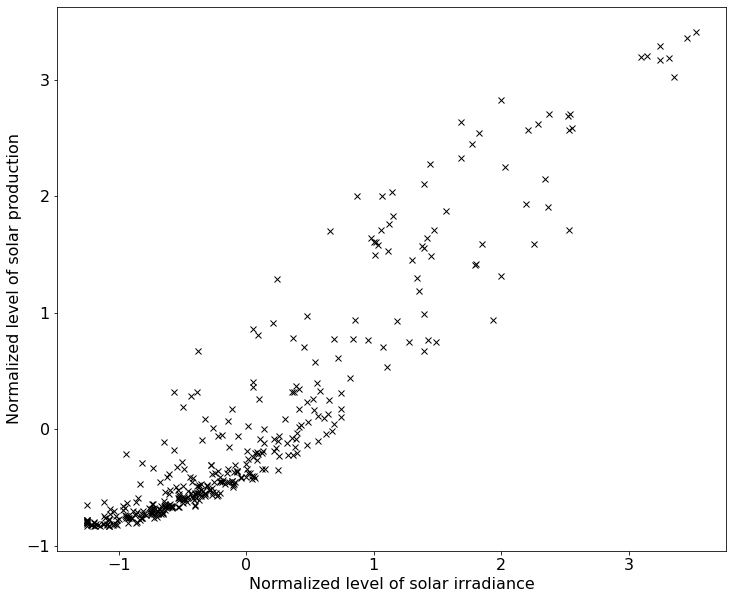

In [7]:
# We plot our normalized x versus y values
plt.figure(figsize=(12,10))
plt.plot(x, y, 'rx', color='black')
plt.ylabel('Normalized level of solar production')
plt.xlabel('Normalized level of solar irradiance')
plt.show()

In [8]:
# Next, we define the test set, that is the range of points we want to use to compute the mean and the variance
Xtest = np.linspace(x.min(), x.max(), 1000).reshape(-1,1)

In [9]:
# We select initial parameters for our GP model.

# We set the noise term relatively high, as we expect a lot of stochastic noise in the solar irradiance to power
# conversion give the number of exogenous variables that impact this relationship

noise = 2
# kernel = ConstantKernel(1.0) + Matern(length_scale=0.5) # Matern(length_scale=0.5) #  RBF(length_scale=0.5)
kernel = ConstantKernel(1.0) + RBF(length_scale=0.5) # Matern(length_scale=0.5) #  RBF(length_scale=0.5)

# Note, we do not optimize the GP yet!
gpr = GaussianProcessRegressor(kernel=kernel, alpha=noise**2, normalize_y=False, optimizer=None)

In [10]:
# We fit the predictive GP model on our training set
gpr.fit(x.reshape(-1, 1), y.ravel())

GaussianProcessRegressor(alpha=4, kernel=1**2 + RBF(length_scale=0.5),
                         optimizer=None)

In [11]:
# Compute posterior predictive mean and covariance
mu_s, cov_s = gpr.predict(Xtest.reshape(-1, 1), return_cov=True)

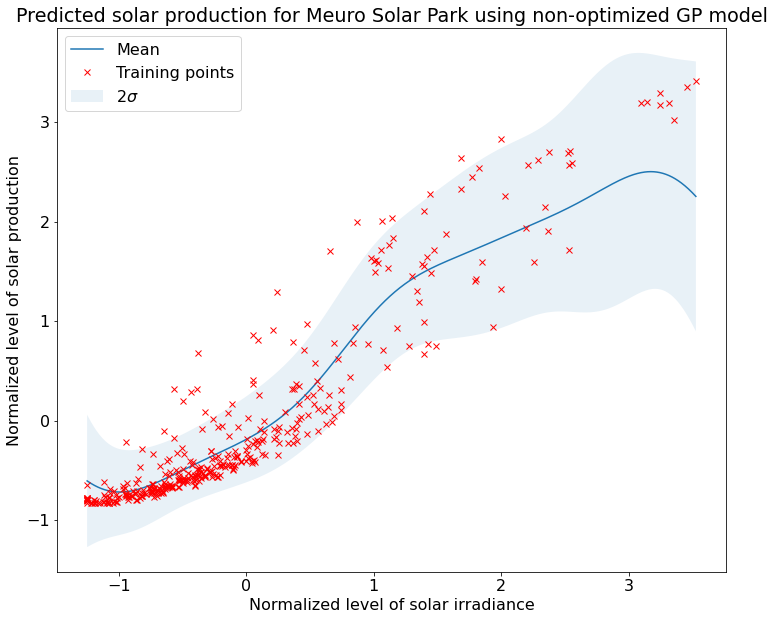

The log likelihood for this fit is 619.7377


In [12]:
# Plot the results
plt.figure(figsize=(12,10))
plot_gp(mu_s, cov_s, Xtest, X_train=x, Y_train=y)
plt.title('Predicted solar production for Meuro Solar Park using non-optimized GP model')
plt.ylabel('Normalized level of solar production')
plt.xlabel('Normalized level of solar irradiance')
plt.show()

print('The log likelihood for this fit is %.4f' % - gpr.log_marginal_likelihood())    

We note that most observations lie in the lower part of the spectrum, which is correspondingly associated with less uncertainty.

Importantly, we notice that high (normalized) levels of solar irradiance are associated with a lot of uncertainty for our estimates!

Now we want to optimize our GP model parameters with the RBF kernel

In [13]:
# Note that we no longer set optimize=False
gpr = GaussianProcessRegressor(kernel=kernel, alpha=noise**2, normalize_y=False)

In [14]:
# We fit similar to last time
gpr.fit(x.reshape(-1, 1), y.ravel())

GaussianProcessRegressor(alpha=4, kernel=1**2 + RBF(length_scale=0.5))

In [15]:
# We compute posterior predictive mean and covariance
mu_s, cov_s = gpr.predict(Xtest.reshape(-1, 1), return_cov=True)

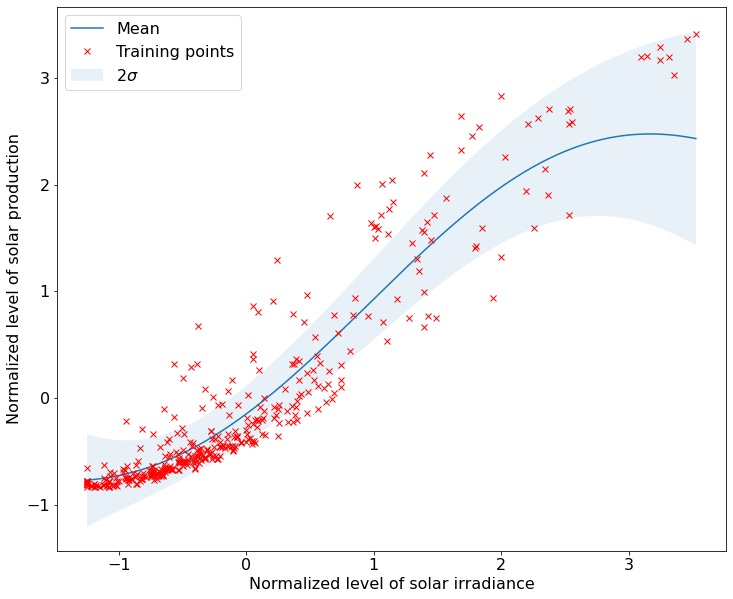

The log likelihood for this fit is 614.4840


In [16]:
# Plot the results
plt.figure(figsize=(12,10))
plot_gp(mu_s, cov_s, Xtest, X_train=x, Y_train=y)
# plt.title('Predicted solar production for Meuro Solar Park using optimized GP model')
plt.ylabel('Normalized level of solar production', fontdict={'size': 16})
plt.xlabel('Normalized level of solar irradiance', fontdict={'size': 16})
plt.show()

print('The log likelihood for this fit is %.4f' % - gpr.log_marginal_likelihood())    

We can see a better fit now (log likelihood is also lower), and the high uncertainty in the upper right corner is reduce considerably!

## 2.2 Predict on the Neuhardenberg Solar Park and quantify uncertainty estimates

In [17]:
# Make predictions on another power plant

x_test = neuhardenberg_irradiance.values.reshape(-1, 1)
y_test = neuhardenberg_sim.values.reshape(-1, 1)

# We save the scalers as we need to convert back to original space when comparing with OLS later
x_test_scaler = StandardScaler().fit(x_test)
y_test_scaler = StandardScaler().fit(y_test)

x_test = x_test_scaler.transform(x_test).ravel()
y_test = y_test_scaler.transform(y_test).ravel()

In [18]:
# We predict the posterior on our test set 
mu_s, cov_s = gpr.predict(x_test.reshape(-1, 1), return_cov=True)

In [19]:
# We need to sort the values, otherwise the uncertainty plot will look strange
sorted_idx = np.argsort(x_test)

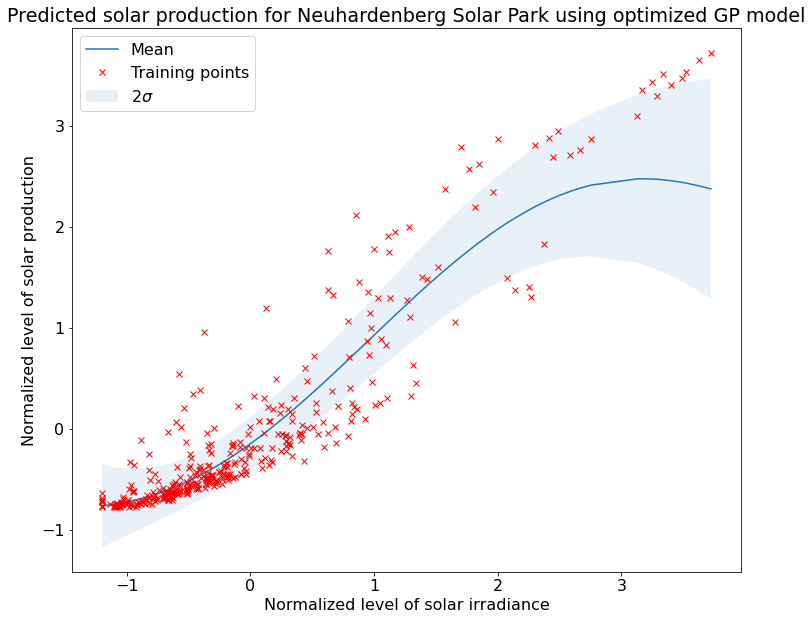

In [20]:
# Plot the results
plt.figure(figsize=(12,10))
uncertainty = 1.96 * np.sqrt(np.diag(cov_s))

upper = mu_s + uncertainty
lower =  mu_s - uncertainty

plt.fill_between(x_test[sorted_idx], upper[sorted_idx], lower[sorted_idx], alpha=0.1, label=r"$2\sigma$")
plt.plot(x_test[sorted_idx], mu_s[sorted_idx], label='Mean')

plt.plot(x_test, y_test, 'rx', label='Training points')
plt.legend()
plt.title('Predicted solar production for Neuhardenberg Solar Park using optimized GP model')
plt.ylabel('Normalized level of solar production')
plt.xlabel('Normalized level of solar irradiance')
plt.show()

Visually, it looks like our model does a relatively good job at describing this solar park, even though it might have a different irradiance to power profile!  

This shows that Gaussian Process are not very prone to overfitting!  

# 2.3 Comparison with linear regression

In [21]:
# Let us calculate rmse and std of our GP

#First, we need to do inverse transform back to original y-space
gp_preds = y_test_scaler.inverse_transform(mu_s)

rmse_gp = np.mean(np.sqrt(np.power(gp_preds - neuhardenberg_sim.values.reshape(-1, 1), 2)))
std_gp = np.std(gp_preds - neuhardenberg_sim.values.reshape(-1, 1))

In [22]:
from sklearn.linear_model import LinearRegression

In [23]:
model = LinearRegression()

model.fit(meuro_irradiance.values.reshape(-1, 1), meuro_sim.values.reshape(-1, 1))

preds_ols = model.predict(neuhardenberg_irradiance.values.reshape(-1, 1),)

In [24]:
rmse_ols = np.mean(np.sqrt(np.power(preds_ols.ravel() - neuhardenberg_sim.values.reshape(-1, 1), 2)))
std_ols = np.std(preds_ols.ravel() - neuhardenberg_sim.values.reshape(-1, 1))

In [25]:
print('RMSE of GP model is {}'.format(round(rmse_gp, 4)))
print('RMSE of OLS model is {}'.format(round(rmse_ols, 4)))

print('STD of GP model is {}'.format(round(std_gp, 4)))
print('STD of OLS model is {}'.format(round(std_ols, 4)))

RMSE of GP model is 0.1487
RMSE of OLS model is 0.1603
STD of GP model is 0.2193
STD of OLS model is 0.2295


### Thus, we can observe our GP model actually provide a more accurate estimate than OLS!
Additionally, we obtain uncertainty estimates which makes it even more valuable compared to the linear parametric model!

# Grow dataset with Active Learning and Gaussian Process

As a final experiment, we will try an active learning strategy, where we start with a small dataset from one power plant and gradually grow it to achieve better predictions on a test set (another power plant).

The idea is:
- We have a small "labelled" dataset (in this case, Meuro Solar Park), that we denote $n$.
- We train a model on $L$, which is our GP from earlier. Since GPs provide a way to quantify uncertainty of the predictions as the covariance function of the process, they can be used directly in an active learning setting.
- Using a query strategy, we determine which samples from the unlabelled dataset (Neuhardenberg Solar Park) are most optimal to label next. 
- We continue this iterative process until we are satisfied with validation / test error.

In [137]:
def GP_regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    return np.argmax(std)

In [150]:
from modAL.models import ActiveLearner
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

n_initial = 5
initial_idx = np.random.choice(range(len(x)), size=n_initial, replace=False)
X_training, y_training = x[initial_idx], y[initial_idx]

# kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
#          + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

regressor = ActiveLearner(
    estimator=GaussianProcessRegressor(kernel=kernel),
    query_strategy=GP_regression_std,
    X_training=X_training.reshape(-1, 1), y_training=y_training.reshape(-1, 1)
)

In [151]:
# We need to sort the values, otherwise the uncertainty plot will look strange
sorted_idx = np.argsort(x_test)

In [152]:
# Predict on the test set
X_grid = x_test[sorted_idx]  
y_gt = y_test[sorted_idx]
y_pred, y_std = regressor.predict(X_grid.reshape(-1, 1), return_std=True)
y_pred, y_std = y_pred.ravel(), y_std.ravel()

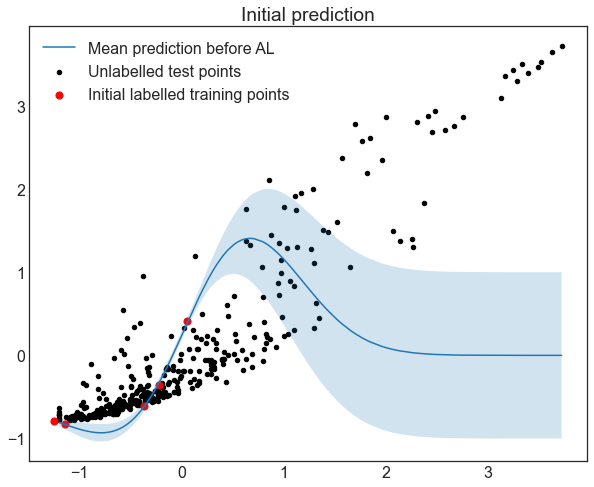

In [153]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 8))
    plt.plot(X_grid, y_pred, label='Mean prediction before AL')
    plt.scatter(X_grid, y_gt, label='Unlabelled test points', c='k', s=20)
    plt.scatter(X_training, y_training, c='r', label='Initial labelled training points', s=50)
    plt.fill_between(X_grid, y_pred - y_std, y_pred + y_std, alpha=0.2)
    plt.title('Initial prediction')
    plt.legend()
    plt.show()

In [126]:
# active learning
n_queries = 10
for idx in range(n_queries):
    query_idx, query_instance = regressor.query(x)
    regressor.teach(x[query_idx].reshape(1, -1), y[query_idx].reshape(1, -1))
    
    y_training = np.concatenate([y_training, y[query_idx].reshape(1, -1)])
    X_training = np.concatenate([X_training, x[query_idx].reshape(1, -1)])

C:\Users\Holm\anaconda3\envs\gaussian_solar_dtu\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [127]:
y_pred_final, y_std_final = regressor.predict(X_grid.reshape(-1, 1), return_std=True)
y_pred_final, y_std_final = y_pred_final.ravel(), y_std_final.ravel()

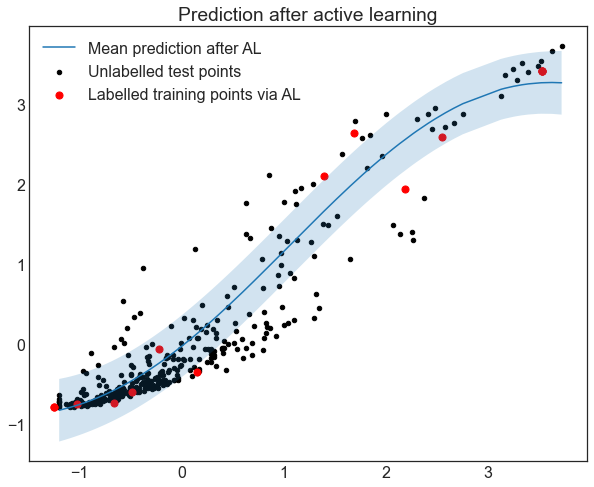

In [128]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 8))
    plt.plot(X_grid, y_pred_final, label='Mean prediction after AL')
    plt.scatter(X_grid, y_gt, label='Unlabelled test points', c='k', s=20)
#     plt.scatter(x, y, label='Unlabelled training points', c='k', s=20)
    plt.scatter(X_training, y_training, c='r', label='Labelled training points via AL', s=50)
    plt.fill_between(X_grid, y_pred_final - y_std_final, y_pred_final + y_std_final, alpha=0.2)
    plt.title('Prediction after active learning')
    plt.legend()
    plt.show()

## Comparison with random sampling

Instead of AL, what if we instead implemented random sampling to see how it compares?

In [129]:
n_initial = 5
initial_idx = np.random.choice(range(len(x)), size=n_initial, replace=False)
X_training, y_training = x[initial_idx], y[initial_idx]

In [130]:
def random_sampling(classifier, X_pool):
    n_samples = len(X_pool)
    query_idx = np.random.choice(range(n_samples))
    return query_idx, X_pool[query_idx]

In [131]:
regressor = ActiveLearner(
    estimator=GaussianProcessRegressor(kernel=kernel),
    query_strategy=random_sampling,
    X_training=X_training.reshape(-1, 1), y_training=y_training.reshape(-1, 1)
)

In [132]:
n_queries = 10
for idx in range(n_queries):
    query_idx, query_instance = regressor.query(x)
    regressor.teach(x[query_idx].reshape(1, -1), y[query_idx].reshape(1, -1))
    
    y_training = np.concatenate([y_training, y[query_idx].reshape(1, -1)])
    X_training = np.concatenate([X_training, x[query_idx].reshape(1, -1)])

In [133]:
y_pred_final, y_std_final = regressor.predict(X_grid.reshape(-1, 1), return_std=True)
y_pred_final, y_std_final = y_pred_final.ravel(), y_std_final.ravel()

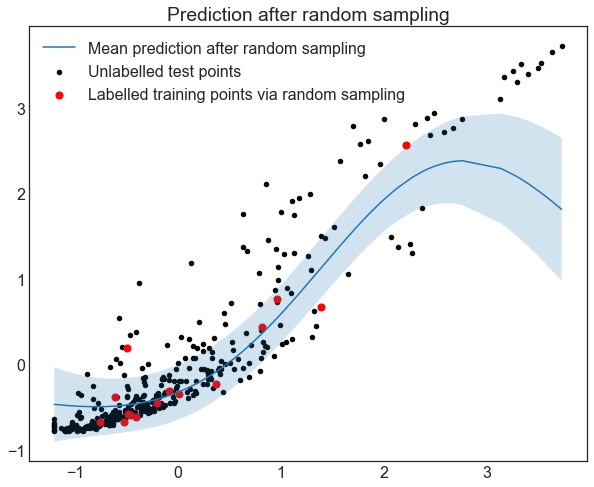

In [135]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 8))
    plt.plot(X_grid, y_pred_final, label='Mean prediction after random sampling')
    plt.scatter(X_grid, y_gt, label='Unlabelled test points', c='k', s=20)
    plt.scatter(X_training, y_training, c='r', label='Labelled training points via random sampling', s=50)
    plt.fill_between(X_grid, y_pred_final - y_std_final, y_pred_final + y_std_final, alpha=0.2)
    plt.title('Prediction after random sampling')
    plt.legend()
    plt.show()